# Multi-Human Tracking with CNN + LSTM
This notebook covers the implementation of a CNN + LSTM model for multi-human tracking


Cell 1: Import Libraries

In [1]:
import os
import json
import cv2
import random
import numpy as np
import logging
import matplotlib.pyplot as plt

# Set logging level for easier debugging
logging.basicConfig(level=logging.INFO)


Cell 2: Define paths to your datasets

In [2]:
# Define paths to your datasets
dataset = './dataset/personpath22/'
raw_dataset = os.path.join( dataset ,'raw_data/')
annotation_folder = './dataset/personpath22/annotation/'
visible_annotations_path = os.path.join(annotation_folder, 'anno_visible_2022')
amodal_annotations_path = os.path.join(annotation_folder, 'anno_amodal_2022')
frames_folder = './dataset/personpath22/extracted_frames/'


Cell 3: Load Annotations

In [3]:
# Function to load annotations from JSON files
def load_annotations(annotation_path):
    annotations = {}
    print(f"Loading annotations from {annotation_path}...")
    for filename in os.listdir(annotation_path):
        if filename.endswith('.json'):
            with open(os.path.join(annotation_path, filename), 'r') as f:
                data = json.load(f)
                annotations[filename] = data
                print(f"Loaded annotation: {filename}")
    print(f"Total annotations loaded: {len(annotations)}")
    return annotations

visible_annotations = load_annotations(visible_annotations_path)
amodal_annotations = load_annotations(amodal_annotations_path)


Loading annotations from ./dataset/personpath22/annotation/anno_visible_2022...
Loaded annotation: uid_vid_00000.mp4.json
Loaded annotation: uid_vid_00001.mp4.json
Loaded annotation: uid_vid_00002.mp4.json
Loaded annotation: uid_vid_00003.mp4.json
Loaded annotation: uid_vid_00004.mp4.json
Loaded annotation: uid_vid_00005.mp4.json
Loaded annotation: uid_vid_00006.mp4.json
Loaded annotation: uid_vid_00007.mp4.json
Loaded annotation: uid_vid_00008.mp4.json
Loaded annotation: uid_vid_00009.mp4.json
Loaded annotation: uid_vid_00010.mp4.json
Loaded annotation: uid_vid_00011.mp4.json
Loaded annotation: uid_vid_00012.mp4.json
Loaded annotation: uid_vid_00013.mp4.json
Loaded annotation: uid_vid_00014.mp4.json
Loaded annotation: uid_vid_00015.mp4.json
Loaded annotation: uid_vid_00016.mp4.json
Loaded annotation: uid_vid_00017.mp4.json
Loaded annotation: uid_vid_00018.mp4.json
Loaded annotation: uid_vid_00019.mp4.json
Loaded annotation: uid_vid_00020.mp4.json
Loaded annotation: uid_vid_00021.mp4.j

Cell 4: Preprocess Videos & Cell 5: Display Sample Frames

Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00000.mp4
Frames for uid_vid_00000 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00001.mp4
Frames for uid_vid_00001 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00002.mp4
Frames for uid_vid_00002 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00003.mp4
Frames for uid_vid_00003 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00004.mp4
Frames for uid_vid_00004 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00005.mp4
Frames for uid_vid_00005 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00006.mp4
Frames for uid_vid_00006 alre

ERROR:root:An error occurred while extracting frames from ./dataset/personpath22/raw_data/uid_vid_00162.mp4: Error opening video file: ./dataset/personpath22/raw_data/uid_vid_00162.mp4


Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00163.mp4
Frames for uid_vid_00163 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00164.mp4
Frames for uid_vid_00164 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00165.mp4
Frames for uid_vid_00165 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00166.mp4
Frames for uid_vid_00166 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00167.mp4
Frames for uid_vid_00167 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00168.mp4
Frames for uid_vid_00168 already extracted. Skipping extraction.
Extracting 60 frames from video: ./dataset/personpath22/raw_data/uid_vid_00169.mp4
Frames for uid_vid_00169 alre

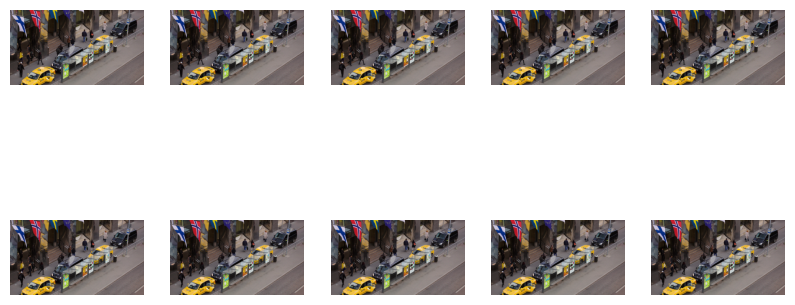

Sample frames displayed.


In [4]:
# Ensure the output folder exists
os.makedirs(frames_folder, exist_ok=True)

# Function to extract frames from a video and save them to disk
def extract_frames_and_save(video_path, frame_count, output_folder):
    print(f"Extracting {frame_count} frames from video: {video_path}")
    try:
        video = cv2.VideoCapture(video_path)
        if not video.isOpened():
            raise ValueError(f"Error opening video file: {video_path}")

        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_count = min(frame_count, total_frames)
        random_frame_indices = random.sample(range(total_frames), frame_count)

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        frame_folder = os.path.join(output_folder, video_name)
        os.makedirs(frame_folder, exist_ok=True)

        existing_frames = len([f for f in os.listdir(frame_folder) if f.endswith('.jpg')])
        if existing_frames >= frame_count:
            print(f"Frames for {video_name} already extracted. Skipping extraction.")
            return

        for index in random_frame_indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, index)
            success, frame = video.read()
            if success:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                cv2.imwrite(os.path.join(frame_folder, f"frame_{index + 1:04d}.jpg"), frame)
            else:
                logging.error(f"Failed to read frame at index {index} from video: {video_path}")

        video.release()
        print(f"Extracted and saved {frame_count} frames from {video_path}")

    except Exception as e:
        logging.error(f"An error occurred while extracting frames from {video_path}: {e}")


# Function to process multiple videos
def process_videos(video_files, frames_per_video, output_folder, clear_memory_after=10):
    for i, video_file in enumerate(video_files):
        video_path = os.path.join(raw_dataset, video_file)
        extract_frames_and_save(video_path, frames_per_video, output_folder)

        # Clear memory after every specified number of videos
        if (i + 1) % clear_memory_after == 0:
            print("Clearing memory...")
            import gc
            gc.collect()

# Parameters
num_frames_per_video = 60  # Number of frames to extract from each video
clear_memory_after_videos = 10  # Clear memory after processing this many videos

# Extract and save frames from all videos
video_files = [f for f in os.listdir(raw_dataset) if f.endswith('.mp4')]
process_videos(video_files, num_frames_per_video, frames_folder, clear_memory_after_videos)

# Function to display frames directly from the output folder
def display_frames_from_folder(folder):
    print(f"Displaying sample frames from {folder}...")
    plt.figure(figsize=(10, 5))
    
    for video_file in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, video_file)):  # Ensure it's a directory
            frame_folder = os.path.join(folder, video_file)
            # Load the first 10 frames from each video folder
            frame_files = [f for f in os.listdir(frame_folder) if f.endswith('.jpg')][:10]
            for i, frame_file in enumerate(frame_files):
                frame_path = os.path.join(frame_folder, frame_file)
                frame = cv2.imread(frame_path)
                if frame is not None:
                    plt.subplot(2, 5, i + 1)
                    plt.imshow(frame)
                    plt.axis('off')
            break  # Remove this if you want to display from all video folders
    plt.show()
    print("Sample frames displayed.")

# Display the random frames directly from the output folder
display_frames_from_folder(frames_folder)



Cell 6: Prepare Data for CNN

In [12]:
import os
import cv2
import numpy as np
import torch
import logging
from torch.nn.utils.rnn import pad_sequence

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set the path for extracted frames and annotation files
frames_folder = './dataset/personpath22/extracted_frames/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Set device to GPU if available

# Combine visible and amodal annotations using previously loaded annotations
def combine_annotations(visible_annotations, amodal_annotations):
    combined = {}
    for video_name, visible_data in visible_annotations.items():
        combined[video_name] = visible_data  # Use visible data as a base
        
        if video_name in amodal_annotations:
            if 'entities' in amodal_annotations[video_name]:
                combined[video_name]['amodal_entities'] = amodal_annotations[video_name]['entities']
            else:
                logging.warning(f"No 'entities' found for {video_name} in amodal annotations.")
    
    return combined

# Combine annotations using previously loaded data
annotations = combine_annotations(visible_annotations, amodal_annotations)
logging.info(f"Combined annotations: {list(annotations.keys())}")

# Function to load pre-stored frames
def load_frames(frames_folder, video_name, target_size=(224, 224)):
    video_name = os.path.splitext(video_name)[0]  # Remove the file extension
    frame_path = os.path.join(frames_folder, video_name)
    logging.info(f"Looking for frames in: {frame_path}")
    
    if os.path.exists(frame_path):
        frame_files = sorted([f for f in os.listdir(frame_path) if f.endswith('.jpg')])
        if len(frame_files) == 0:
            logging.warning(f"No JPG files found in: {frame_path}")
        
        frames = []
        for frame_file in frame_files:
            frame = cv2.imread(os.path.join(frame_path, frame_file))
            if frame is not None:
                frame_resized = cv2.resize(frame, target_size)
                frames.append(torch.tensor(frame_resized.transpose(2, 0, 1), dtype=torch.float32))  # Move channels to the front
            else:
                logging.warning(f"Frame could not be loaded: {frame_file}")
        return frames
    else:
        logging.warning(f"No frames found for {video_name} in {frames_folder}")
        return None

# Function to prepare data for CNN with padding
def prepare_cnn_data(video_count=60, save_path='./dataset/personpath22/hybrid_cnn.npz', target_size=(224, 224)):
    X, y = [], []
    logging.info("Preparing CNN data...")

    for video_file, annotation in annotations.items():
        if len(X) >= video_count:
            break
        
        video_name = os.path.splitext(video_file)[0]
        logging.info(f"Processing video: {video_name} with annotations: {annotation}")

        frames = load_frames(frames_folder, video_name, target_size)

        if frames is not None and len(frames) > 0:
            logging.info(f"Loaded frames for {video_file}: {len(frames)} frames")
            
            if annotation.get('entities'):
                X.append(frames)
                label = annotation['entities'][0]['bb']  # Example for bounding box
                y.append(label)
            else:
                logging.warning(f"No valid entities found in annotation for {video_file}")
        else:
            logging.error(f"Frames loading failed for {video_file}")

    if len(X) > 0 and len(y) > 0:
        # Pad sequences to the maximum length
        X_padded = pad_sequence([torch.stack(frames) for frames in X], batch_first=True)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

        # Save processed data
        np.savez_compressed(save_path, X=X_padded.cpu().numpy(), y=y_tensor.cpu().numpy())
        logging.info(f"Processed CNN data saved: Length of X_cnn: {X_padded.shape}, Length of y_cnn: {y_tensor.shape}")
        return X_padded, y_tensor
    else:
        logging.info("No valid data to save.")
        return None, None

# Load or prepare data for CNN
if os.path.exists('./dataset/personpath22/hybrid_cnn.npz'):
    logging.info("Loading processed CNN data...")
    data = np.load('./dataset/personpath22/hybrid_cnn.npz')
    X_cnn, y_cnn = [torch.tensor(x).to(device) for x in data['X']], torch.tensor(data['y']).to(device)
else:
    X_cnn, y_cnn = prepare_cnn_data()

    # Step 2: Load Data into Tensors
# This is where you load your image data into X_cnn and labels into y_cnn
# Example (replace with your actual loading logic):
X_cnn = [torch.rand(3, 224, 224).to('cuda') for _ in range(60)]  # List of tensors
y_cnn = [torch.rand(1).to('cuda') for _ in range(60)]             # List of tensors

# Step 3: Convert Tensors to NumPy Arrays
import numpy as np

# Convert tensor lists to NumPy arrays
if isinstance(X_cnn, list):
    X_cnn = np.array([x.cpu().numpy() for x in X_cnn], dtype=np.float32)

if isinstance(y_cnn, list):
    y_cnn = np.array([y.cpu().numpy() for y in y_cnn], dtype=np.float32)

# Now you can proceed with model definition and training
print("X_cnn shape:", X_cnn.shape)  # Output the shape of the array
print("y_cnn shape:", y_cnn.shape)  # Output the shape of the array


INFO:root:Combined annotations: ['uid_vid_00000.mp4.json', 'uid_vid_00001.mp4.json', 'uid_vid_00002.mp4.json', 'uid_vid_00003.mp4.json', 'uid_vid_00004.mp4.json', 'uid_vid_00005.mp4.json', 'uid_vid_00006.mp4.json', 'uid_vid_00007.mp4.json', 'uid_vid_00008.mp4.json', 'uid_vid_00009.mp4.json', 'uid_vid_00010.mp4.json', 'uid_vid_00011.mp4.json', 'uid_vid_00012.mp4.json', 'uid_vid_00013.mp4.json', 'uid_vid_00014.mp4.json', 'uid_vid_00015.mp4.json', 'uid_vid_00016.mp4.json', 'uid_vid_00017.mp4.json', 'uid_vid_00018.mp4.json', 'uid_vid_00019.mp4.json', 'uid_vid_00020.mp4.json', 'uid_vid_00021.mp4.json', 'uid_vid_00022.mp4.json', 'uid_vid_00023.mp4.json', 'uid_vid_00024.mp4.json', 'uid_vid_00025.mp4.json', 'uid_vid_00026.mp4.json', 'uid_vid_00027.mp4.json', 'uid_vid_00028.mp4.json', 'uid_vid_00029.mp4.json', 'uid_vid_00030.mp4.json', 'uid_vid_00031.mp4.json', 'uid_vid_00032.mp4.json', 'uid_vid_00033.mp4.json', 'uid_vid_00034.mp4.json', 'uid_vid_00035.mp4.json', 'uid_vid_00036.mp4.json', 'uid_

X_cnn shape: (60, 3, 224, 224)
y_cnn shape: (60, 1)


Cell 7: Define CNN Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super(CNNModel, self).__init__()
        print("Initializing CNN Model...")
        self.conv1 = nn.Conv2d(in_channels=input_shape[1], out_channels=32, kernel_size=(3, 3), padding=1)
        print("Added Conv2d layer: Conv1 with 32 filters")
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        print("Added Conv2d layer: Conv2 with 64 filters")
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (input_shape[2] // 4) * (input_shape[3] // 4), 128)  # Adjust size according to pooling
        print(f"Added Linear layer: FC1 with {64 * (input_shape[2] // 4) * (input_shape[3] // 4)} input features")
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)  # Output layer for bounding box coordinates
        print("Added Linear layer: FC2 with 4 output features")

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.conv1(x))  # Apply first conv layer and ReLU
        print(f"After Conv1 shape: {x.shape}")  # Print shape after Conv1
        x = self.pool(x)            # Apply first pooling layer
        print(f"After Pool1 shape: {x.shape}")  # Print shape after Pool1
        x = F.relu(self.conv2(x))  # Apply second conv layer and ReLU
        print(f"After Conv2 shape: {x.shape}")  # Print shape after Conv2
        x = self.pool(x)            # Apply second pooling layer
        print(f"After Pool2 shape: {x.shape}")  # Print shape after Pool2
        x = self.flatten(x)         # Flatten the output
        print(f"After Flatten shape: {x.shape}")  # Print shape after Flatten
        x = F.relu(self.fc1(x))     # Fully connected layer with ReLU
        print(f"After FC1 shape: {x.shape}")  # Print shape after FC1
        x = self.dropout(x)         # Apply dropout
        x = self.fc2(x)             # Final output layer
        print(f"Output shape: {x.shape}")  # Print final output shape
        return x

# Define the input shape for the model
input_shape = (60, 3, 224, 224)  # (sequence_length, channels, height, width)

# Create the model and move it to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNNModel(input_shape).to(device)

# Print the model summary
def print_model_summary(model, input_size):
    from torchsummary import summary
    print("Printing model summary...")
    summary(model, input_size=input_size)

print_model_summary(cnn_model, (3, 224, 224))  # Input size for a single frame


Initializing CNN Model...
Added Conv2d layer: Conv1 with 32 filters
Added Conv2d layer: Conv2 with 64 filters
Added Linear layer: FC1 with 200704 input features
Added Linear layer: FC2 with 4 output features
Printing model summary...
Input shape: torch.Size([2, 3, 224, 224])
After Conv1 shape: torch.Size([2, 32, 224, 224])
After Pool1 shape: torch.Size([2, 32, 112, 112])
After Conv2 shape: torch.Size([2, 64, 112, 112])
After Pool2 shape: torch.Size([2, 64, 56, 56])
After Flatten shape: torch.Size([2, 200704])
After FC1 shape: torch.Size([2, 128])
Output shape: torch.Size([2, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
           Flatten-5         

Cell 8: Train CNN Model

Splitting CNN data for training and validation...
Training data length: 48, Validation data length: 12
Input shape: torch.Size([2, 3, 224, 224])
After Conv1 shape: torch.Size([2, 32, 224, 224])
After Pool1 shape: torch.Size([2, 32, 112, 112])
After Conv2 shape: torch.Size([2, 64, 112, 112])
After Pool2 shape: torch.Size([2, 64, 56, 56])
After Flatten shape: torch.Size([2, 200704])
After FC1 shape: torch.Size([2, 128])
Output shape: torch.Size([2, 4])


c:\Users\Joshua Menezes\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Input shape: torch.Size([2, 3, 224, 224])
After Conv1 shape: torch.Size([2, 32, 224, 224])
After Pool1 shape: torch.Size([2, 32, 112, 112])
After Conv2 shape: torch.Size([2, 64, 112, 112])
After Pool2 shape: torch.Size([2, 64, 56, 56])
After Flatten shape: torch.Size([2, 200704])
After FC1 shape: torch.Size([2, 128])
Output shape: torch.Size([2, 4])
Input shape: torch.Size([2, 3, 224, 224])
After Conv1 shape: torch.Size([2, 32, 224, 224])
After Pool1 shape: torch.Size([2, 32, 112, 112])
After Conv2 shape: torch.Size([2, 64, 112, 112])
After Pool2 shape: torch.Size([2, 64, 56, 56])
After Flatten shape: torch.Size([2, 200704])
After FC1 shape: torch.Size([2, 128])
Output shape: torch.Size([2, 4])
Input shape: torch.Size([2, 3, 224, 224])
After Conv1 shape: torch.Size([2, 32, 224, 224])
After Pool1 shape: torch.Size([2, 32, 112, 112])
After Conv2 shape: torch.Size([2, 64, 112, 112])
After Pool2 shape: torch.Size([2, 64, 56, 56])
After Flatten shape: torch.Size([2, 200704])
After FC1 shape

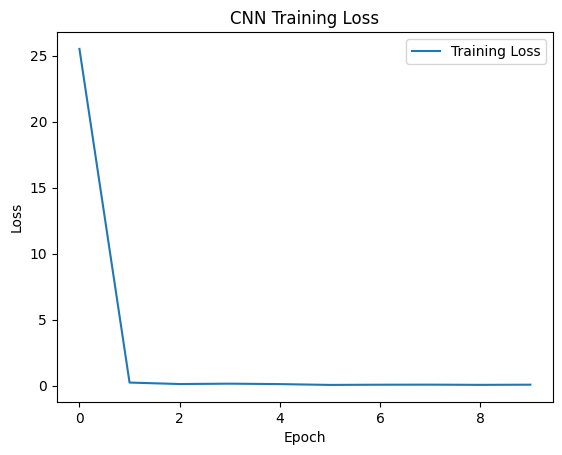

In [14]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assume X_cnn and y_cnn are defined here; replace with your actual data loading logic
# For example:
# X_cnn = [np.random.rand(3, 224, 224) for _ in range(60)]
# y_cnn = [np.random.rand(1) for _ in range(60)]

# Ensure X_cnn and y_cnn are lists or tensors
if isinstance(X_cnn, list):
    X_cnn = np.array(X_cnn, dtype=np.float32)  # Convert list of images to numpy array
if isinstance(y_cnn, list):
    y_cnn = np.array(y_cnn, dtype=np.float32)  # Convert list of labels to numpy array

# Check dimensions to avoid reshaping issues later
assert X_cnn.ndim == 4, "X_cnn must be 4D (num_samples, channels, height, width)"
assert y_cnn.ndim == 1 or y_cnn.ndim == 2, "y_cnn must be 1D or 2D"

# Convert to PyTorch tensors and move to CPU if they're on GPU
X_cnn = torch.tensor(X_cnn, dtype=torch.float32)  # Convert to tensor
y_cnn = torch.tensor(y_cnn, dtype=torch.float32)  # Convert to tensor

# Move to CPU if they are on GPU (just in case)
X_cnn = X_cnn.cpu()
y_cnn = y_cnn.cpu()

# Split data for training and validation
print("Splitting CNN data for training and validation...")
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn.numpy(), y_cnn.numpy(), test_size=0.2, random_state=42)
print(f"Training data length: {len(X_train_cnn)}, Validation data length: {len(X_val_cnn)}")

# Convert to PyTorch tensors and move to GPU
X_train_cnn = torch.tensor(X_train_cnn, dtype=torch.float32).to(device)
X_val_cnn = torch.tensor(X_val_cnn, dtype=torch.float32).to(device)
y_train_cnn = torch.tensor(y_train_cnn, dtype=torch.float32).to(device)
y_val_cnn = torch.tensor(y_val_cnn, dtype=torch.float32).to(device)

# Define a function to train the CNN model
def train_cnn_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    model.train()
    train_losses = []  # List to store training losses
    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0  # Reset epoch loss
        
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            # Reshape to [batch_size * frames, channels, height, width]
            batch_x = batch_x.view(-1, 3, 224, 224)  # Adjust to shape [batch_size * frames, channels, height, width]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / (X_train.size(0) // batch_size)
        train_losses.append(avg_loss)  # Store average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

    print("CNN model training completed.")
    return train_losses  # Return training losses

# Train the CNN model and capture losses
cnn_losses = train_cnn_model(cnn_model, X_train_cnn, y_train_cnn, X_val_cnn, y_val_cnn)

# Plot the training losses
plt.plot(cnn_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss')
plt.legend()
plt.show()


Cell 9: Prepare Data for LSTM

In [15]:
# Cell 9: Prepare Data for LSTM

# %% 
def prepare_lstm_data(video_count=60, frame_count=60, save_path='./dataset/personpath22/lstm_data.npz'):
    X_lstm, y_lstm = [], []
    print("Preparing LSTM data...")
    
    for video_file, annotation in annotations.items():
        if len(X_lstm) >= video_count:
            break
        
        video_name = os.path.splitext(video_file)[0]
        frames = load_frames(frames_folder, video_name)

        if frames is not None and len(frames) >= frame_count:
            # Select the first 'frame_count' frames for simplicity
            X_lstm.append(frames[:frame_count])
            if annotation.get('entities'):
                label = annotation['entities'][0]['bb']  # Example for bounding box
                y_lstm.append(label)
            else:
                print(f"No valid entities found in annotation for {video_file}")
        else:
            print(f"Insufficient frames extracted for {video_file}")

    if len(X_lstm) > 0 and len(y_lstm) > 0:
        # Convert to PyTorch tensors and move to GPU
        X_lstm_tensor = torch.stack([torch.stack(frames) for frames in X_lstm]).to(device)
        y_lstm_tensor = torch.tensor(y_lstm, dtype=torch.float32).to(device)

        # Save processed data
        np.savez_compressed(save_path, X=X_lstm_tensor.cpu().numpy(), y=y_lstm_tensor.cpu().numpy())
        print(f"Processed LSTM data saved: Length of X_lstm: {X_lstm_tensor.shape}, Length of y_lstm: {y_lstm_tensor.shape}")
        return X_lstm_tensor, y_lstm_tensor
    else:
        print("No valid data to save.")
        return None, None

# Load or prepare data for LSTM
if os.path.exists('./dataset/personpath22/lstm_data.npz'):
    print("Loading processed LSTM data...")
    data = np.load('./dataset/personpath22/lstm_data.npz')
    X_lstm, y_lstm = [torch.tensor(x).to(device) for x in data['X']], torch.tensor(data['y']).to(device)
else:
    X_lstm, y_lstm = prepare_lstm_data()

INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00000


Preparing LSTM data...


INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00001
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00002
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00003
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00004
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00005
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00006
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00007
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00008
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00009
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00010
INFO:root:Looking for frames in: ./dataset/personpath22/extracted_frames/uid_vid_00011
INFO:root:Looking for frames in: ./dataset/

Processed LSTM data saved: Length of X_lstm: torch.Size([60, 60, 3, 224, 224]), Length of y_lstm: torch.Size([60, 4])


Cell 10: Define LSTM Model

In [16]:
# Cell 10: Define LSTM Model

# %% 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only get the last output
        return out

# Define LSTM model parameters
input_size = 3 * 224 * 224  # Input size (channels * height * width)
hidden_size = 64  # Number of LSTM hidden units
output_size = 4  # Output size (bounding box coordinates)

# Create the LSTM model and move to GPU if available
lstm_model = LSTMModel(input_size, hidden_size, output_size).to(device)

# Print the model summary
print(lstm_model)

LSTMModel(
  (lstm): LSTM(150528, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


Cell 11: Train LSTM Model

In [17]:
# %% 
def train_lstm_model(model, X_train, y_train, epochs=10, batch_size=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    train_losses = []  # List to store training losses
    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0  # Reset epoch loss
        
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x.view(batch_x.size(0), -1, input_size))  # Reshape for LSTM
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / (X_train.size(0) // batch_size)
        train_losses.append(avg_loss)  # Store average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

    print("LSTM model training completed.")
    return train_losses  # Return training losses

# Train the LSTM model and capture losses
lstm_losses = train_lstm_model(lstm_model, X_lstm, y_lstm)

Epoch [1/10], Loss: 344278.1956
Epoch [2/10], Loss: 343902.0182
Epoch [3/10], Loss: 343543.8125
Epoch [4/10], Loss: 343143.0021
Epoch [5/10], Loss: 342764.9474
Epoch [6/10], Loss: 342387.6758
Epoch [7/10], Loss: 342031.3245
Epoch [8/10], Loss: 341676.2826
Epoch [9/10], Loss: 341319.4513
Epoch [10/10], Loss: 340977.8617
LSTM model training completed.


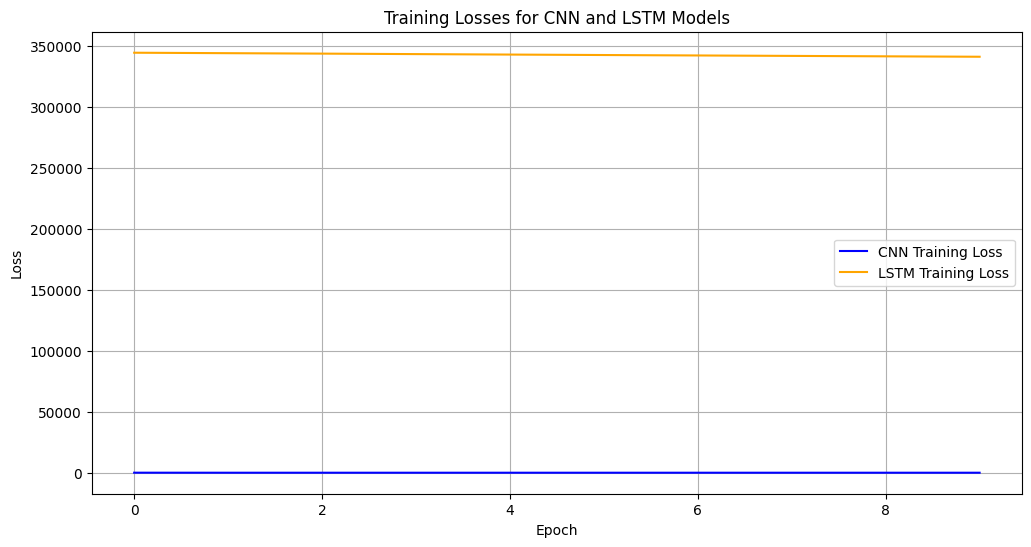

In [18]:
# Cell 12: Plot Training Losses

# %%
# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(cnn_losses, label='CNN Training Loss', color='blue')
plt.plot(lstm_losses, label='LSTM Training Loss', color='orange')
plt.title('Training Losses for CNN and LSTM Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Cell 12: Save Models

In [ ]:
# # Save the models
# print("Saving models...")
# cnn_model.save('cnn_model.h5')
# lstm_model.save('lstm_model.h5')
# print("Models saved.")
